In [1]:
import scipy.io
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
# import Dense 

data = scipy.io.loadmat('mass_spring.mat')

p = data['p']
q = data['q']
dq_dt = data['dq']
dp_dt = data['dp']
H_true = data['output']

N = p.shape[0]


Modelo

In [2]:
learning_rate = 0.01
training_steps = 1000
display_step = 10

# model
tf.random.set_seed(0)
NN = tf.keras.Sequential()
NN.add(tf.keras.Input(shape=(2,)))
NN.add(Dense(16, activation='tanh'))
NN.add(Dense(16, activation='tanh'))
NN.add(Dense(16, activation='tanh'))
NN.add(Dense(1, activation=None))
NN.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


### definir función de costo

In [3]:
@tf.function
def loss(NN, p, q, dp, dq):
    qp = tf.concat([q, p], axis=1)
    dpq_dt = tf.concat([-dp, dq], axis=1)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(qp)
        H = NN(qp)
    dH_dqp = tape.gradient(H, qp)
    
    L_HNN = tf.norm(dH_dqp - dpq_dt, axis=1, ord='euclidean')**2
    mean_loss = tf.reduce_mean(L_HNN)
    
    return mean_loss

In [4]:
@tf.function
def train_step(NN, p, q, dp, dq, optimizer):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(NN.trainable_variables)
        loss_value = loss(NN, p, q, dp, dq)
    grads = tape.gradient(loss_value, NN.trainable_variables)
    del tape
    optimizer.apply_gradients(zip(grads, NN.trainable_variables))
    return loss_value

In [5]:
def train(NN, optimizer, training_steps):
    loss_values = []
    for step in range(training_steps):
        loss_value = train_step(NN, p, q, dp_dt, dq_dt, optimizer)
        loss_values.append(loss_value)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss_value))
    return loss_values

In [6]:
tf.random.set_seed(0)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
loss_values = train(NN, adam_optimizer, training_steps)

step: 0, loss: 2.036724
step: 10, loss: 1.269887
step: 20, loss: 1.092011
step: 30, loss: 1.042654
step: 40, loss: 1.014957
step: 50, loss: 1.011774
step: 60, loss: 1.009739
step: 70, loss: 1.008196
step: 80, loss: 1.007931
step: 90, loss: 1.007804
step: 100, loss: 1.007662
step: 110, loss: 1.007597
step: 120, loss: 1.007543
step: 130, loss: 1.007501
step: 140, loss: 1.007467
step: 150, loss: 1.007439
step: 160, loss: 1.007416
step: 170, loss: 1.007396
step: 180, loss: 1.007380
step: 190, loss: 1.007366
step: 200, loss: 1.007354
step: 210, loss: 1.007344
step: 220, loss: 1.007336
step: 230, loss: 1.007329
step: 240, loss: 1.007323
step: 250, loss: 1.007317
step: 260, loss: 1.007313
step: 270, loss: 1.007308
step: 280, loss: 1.007305
step: 290, loss: 1.007301
step: 300, loss: 1.007298
step: 310, loss: 1.007295
step: 320, loss: 1.007292
step: 330, loss: 1.007290
step: 340, loss: 1.007288
step: 350, loss: 1.007286
step: 360, loss: 1.007284
step: 370, loss: 1.007282
step: 380, loss: 1.0072

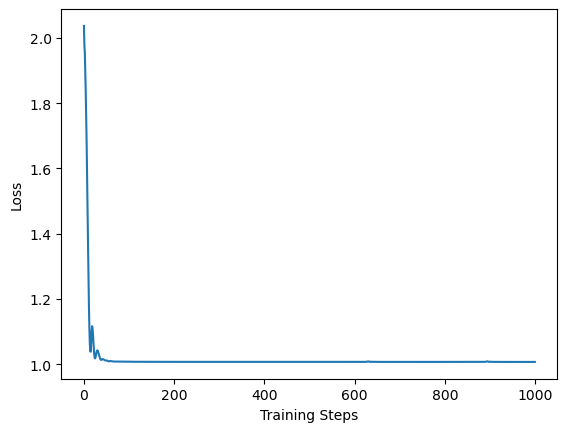

In [8]:
plt.plot(loss_values)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()

Gráficas

In [9]:
T = 10
Mt = T*1000
h = T/Mt

trajectory_p = []
trajectory_q = []
trajectory_H = []

j = 1
p_ = tf.constant(j, dtype=tf.float32)
q_ = tf.constant(0, dtype=tf.float32)

for k in range (0, Mt):
    trajectory_p.append(p_)
    trajectory_q.append(q_)

    qp = tf.reshape(tf.concat([[q_, p_]], axis=1), [1, 2])
    with tf.GradientTape() as g:
        g.watch(qp)
        H = NN(qp)
        trajectory_H.append(H.numpy().flatten()[0])   
    DH = g.gradient(H, qp)
    q_ = q_ + h*DH[0, 1]
    p_ = p_ - h*DH[0, 0]

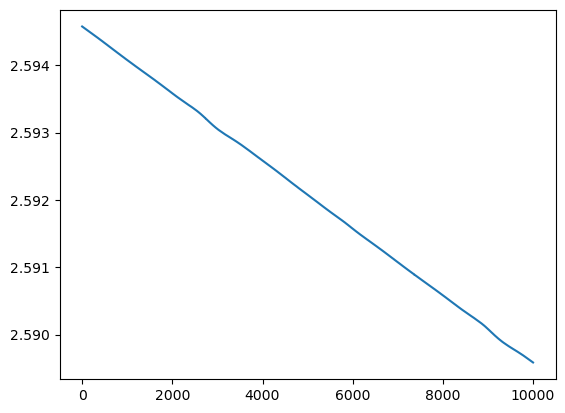

In [10]:
plt.plot(trajectory_H)

Text(0, 0.5, 'q')

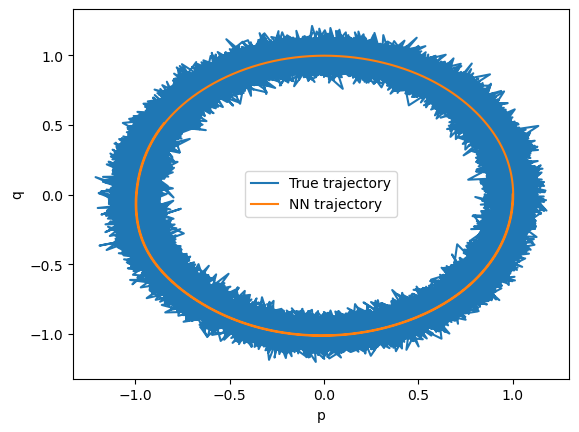

In [12]:
plt.plot(p, q, label='True trajectory')
plt.plot(trajectory_p, trajectory_q, label='NN trajectory')
plt.legend()
plt.xlabel('p')
plt.ylabel('q')